<a href="https://colab.research.google.com/github/albuut/Medical-Malpractice-Analysis/blob/bayesian_regression/CS203_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [56]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pyplot

# Medical Malpractice Analysis

# Google Colab Startup
Make sure to clone the repository into the Google Colab.

In [2]:
!git clone https://github.com/albuut/Medical-Malpractice-Analysis.git

Cloning into 'Medical-Malpractice-Analysis'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 152 (delta 20), reused 10 (delta 10), pack-reused 126
Receiving objects: 100% (152/152), 708.49 KiB | 4.72 MiB/s, done.
Resolving deltas: 100% (77/77), done.


Run the following code.

In [3]:
%cd /content/Medical-Malpractice-Analysis/

/content/Medical-Malpractice-Analysis


# Data Cleaning

Data manipulated from the original data set.

1. Amount: Log(Amount)

2. Speciality: Dummy variable encoded into different specialities.

3. Insurance: Dummy variable enconded into different insurances.

4. Marital Status: Dummy variable econded into different marital status.

5. Gender: One hot encoded gender for Male = 0 and Female = 1.

The data is also split into three categories.
1. Training: 60%
2. Validation: 20%
3. Testing: 20%

The decison to convert insurance and martial status to become dummy variable encoded was so that we did not have to worry about the numbering of the enumerated variables imply there was a form of ordinality.

Some things to consider for future development is to not remove the unknown's completely from the data set. There could be corrleations where divoriced people do not put their insurance information down. Future reticfication would be to think about how to assign some value to them. Another improvement could be using Stratified Sampling.





## proccess_data.py
```python
import pandas as pd
import numpy as np
import sys

def dummy_variable_col(df, col):
    df_temp = pd.get_dummies(df[col])
    df_temp = df_temp.astype(int)
    df = pd.concat([df,df_temp],axis=1,).reindex(df.index)
    df.drop(col,axis=1,inplace=True)
    return df

## python3 function_name input output log_base
errors = []

if(len(sys.argv) == 4):
    file_input = sys.argv[1]
    file_output = sys.argv[2]
    log_base = sys.argv[3]
else:
    errors.append("Invalid Number of Arguments")

if(len(errors) == 0):
    try:
        df = pd.read_csv(file_input)
    except Exception as e:
        errors.append("Invalid file input / Could not find file")
    
    if(len(errors) == 0):
        #Log the Data
        if log_base == '10':
            df['log_Amount'] = np.log10(df['Amount'])
        elif log_base == '2':
            df['log_Amount'] = np.log2(df['Amount'])
        elif log_base == 'ln':
            df['log_Amount'] = np.log(df['Amount'])
        else:
            errors.append('Invalid 3rd Argument: Use 10, 2, or ln')
        col_move = df.pop('log_Amount')
        df.insert(loc=1,column='log_Amount',value=col_move)
if(len(errors) == 0):
    #Speciality
    df = dummy_variable_col(df,'Specialty')
    #Insurance
    df = df[df['Insurance'].str.contains("Unknown") == False]
    df = dummy_variable_col(df,'Insurance')
    #Marital Status
    df = df[df['Marital Status'] != 4]
    df = dummy_variable_col(df,'Marital Status')
    df = df.rename(columns={0:'Divorced', 1:'Single', 2:'Married', 3:'Widowed'})
    #Gender Binary Encode
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
    
    #Shuffle Data and Split
    #Consider checking out stratified splitting
    train, validate, test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(.8*len(df))])
    
    train = train.reset_index(drop=True) #60%
    validate = validate.reset_index(drop=True) #20%
    test = test.reset_index(drop=True) #20%
    
    total_data = len(train) + len(validate) + len(test)
    
    train.to_csv(file_output + '_train.csv', index=False)
    print("Successfully written data to: " + file_output + '_train.csv')
    validate.to_csv(file_output + '_validate.csv', index=False)
    print("Successfully written data to: " + file_output + '_validate.csv')
    test.to_csv(file_output + '_test.csv', index =False)
    print("Successfully written data to: " + file_output + '_test.csv')
    
else:
    for e in reversed(errors):
        print(e)
```

We can use the following lines to generate the cleaned up data from csv file with different log values down below.

In [4]:
!python process_data.py medicalmalpractice.csv log10_data 10
!python process_data.py medicalmalpractice.csv log2_data 2
!python process_data.py medicalmalpractice.csv ln_data ln

Successfully written data to: log10_data_train.csv
Successfully written data to: log10_data_validate.csv
Successfully written data to: log10_data_test.csv
Successfully written data to: log2_data_train.csv
Successfully written data to: log2_data_validate.csv
Successfully written data to: log2_data_test.csv
Successfully written data to: ln_data_train.csv
Successfully written data to: ln_data_validate.csv
Successfully written data to: ln_data_test.csv


We then display the origonal data down below.

In [5]:
df_original = pd.read_csv('medicalmalpractice.csv')
df_original

,Amount,Severity,Age,Private Attorney,Marital Status,Specialty,Insurance,Gender
0,57041,7,62,1,2,Family Practice,Private,Male
1,324976,6,38,1,2,OBGYN,No Insurance,Female
2,135383,4,34,1,2,Cardiology,Unknown,Male
3,829742,7,42,1,1,Pediatrics,No Insurance,Female
4,197675,3,60,0,2,OBGYN,Medicare/Medicaid,Female
...,...,...,...,...,...,...,...,...
79205,25305,4,64,1,2,General Surgery,Unknown,Male
79206,43098,3,87,0,4,Orthopedic Surgery,Unknown,Male
79207,35398,3,81,0,4,Anesthesiology,Unknown,Male
79208,154228,9,19,0,4,Dermatology,Unknown,Female


We can then observe how the data is cleaned and seperated into different variables to be used in different forms of regression or analysis.

In [6]:
df_log10 = pd.read_csv('log10_data_train.csv')
df_log10

,Amount,log_Amount,Severity,Age,Private Attorney,Gender,Anesthesiology,Cardiology,Dermatology,Emergency Medicine,...,Thoracic Surgery,Urological Surgery,Medicare/Medicaid,No Insurance,Private,Workers Compensation,Divorced,Single,Married,Widowed
0,140886,5.148868,2,44,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,168086,5.225532,3,18,1,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
2,36517,4.562495,6,24,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,53077,4.724906,5,51,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,117796,5.071131,5,57,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29519,431789,5.635272,6,44,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
29520,153729,5.186756,7,39,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
29521,829640,5.918890,7,48,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
29522,37970,4.579441,3,41,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


# Bayesian Ridge Regression

Initalize variables and read data.

In [49]:
base_file = 'ln_data'

#Untuned Bayesian Regression
base_regressor = BayesianRidge()
#Untuned Bayesian Regression with Transform
log_base_regressor = BayesianRidge()

#Tuned Bayesian Regression
tuned_regressor = BayesianRidge()
#Tuned Log Bayesian Regression
log_tuned_regressor = BayesianRidge()

#File suffixes
train_suffix = '_train.csv'
validate_suffix = '_validate.csv'
test_suffix = '_test.csv'

#Read Data from File
df_bay_train = pd.read_csv(base_file + train_suffix)
df_bay_validate = pd.read_csv(base_file + validate_suffix)
df_bay_test = pd.read_csv(base_file + test_suffix)

#Testing what happens when removing speciality
#df_bay_train = df_bay_train.drop(columns=df_bay_train.columns[6:26])
#df_bay_validate = df_bay_validate.drop(columns=df_bay_validate.columns[6:26])
#df_bay_test = df_bay_test.drop(columns=df_bay_test.columns[6:26])

#Extract our features and our Y
train_x, train_y, log_train_y = df_bay_train.drop(columns=['Amount','log_Amount']), df_bay_train['Amount'], df_bay_train['log_Amount']

#Seed values for initalized hyperparameters for RandomizedSearchCV
bayesian_param = {
    'alpha_1': np.linspace(1e-2,3,num=200),
    'alpha_2': np.linspace(1e-2,3,num=200),
    'lambda_1': np.linspace(1e-2,3,num=200),
    'lambda_2':np.linspace(1e-2,3,num=200)
}

Search for the best hyperparameters using RandomizedSearchCV and establishing the models

In [50]:
#Randomized Search to find the best hyperparameters without transform
tuned_cv = RandomizedSearchCV(tuned_regressor, param_distributions=bayesian_param,n_iter=100, cv=10, verbose=1,n_jobs=10,random_state=1)
tuned_cv.fit(train_x,train_y)
tuned_param = tuned_cv.best_params_

#Randomized Search to find the best hyperparameters with transform
log_tuned_cv = RandomizedSearchCV(log_tuned_regressor, param_distributions=bayesian_param,n_iter=100, cv=10, verbose=1,n_jobs=10,random_state=1)
log_tuned_cv.fit(train_x,log_train_y)
log_tuned_param = log_tuned_cv.best_params_

#Model with hyperparamters
tuned_model = BayesianRidge(alpha_1 = tuned_param['alpha_1'], alpha_2 = tuned_param['alpha_2'], lambda_1 = tuned_param['lambda_1'], lambda_2 = tuned_param['lambda_2'])
tuned_model.fit(train_x,train_y)

#Log model with hyperparameters
log_tuned_model = BayesianRidge(alpha_1 = log_tuned_param['alpha_1'], alpha_2 = log_tuned_param['alpha_2'], lambda_1 = log_tuned_param['lambda_1'], lambda_2 = log_tuned_param['lambda_2'])
log_tuned_model.fit(train_x, log_train_y)

#Base Regressors
base_regressor.fit(train_x,train_y)
log_base_regressor.fit(train_x, log_train_y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


BayesianRidge()

Use our validation data to determine the performance of our different models.

In [51]:
#Extract Data from the Validation data set to train the hyperparameter
validate_x, validate_y, log_validate_y = df_bay_validate.drop(columns=['Amount','log_Amount']), df_bay_validate['Amount'], df_bay_validate['log_Amount']

#Predict off the validaton data
base_bay_predict_validate = base_regressor.predict(validate_x)
log_bay_predict_validate = log_base_regressor.predict(validate_x)
tuned_bay_predict_validate = tuned_model.predict(validate_x)
log_tuned_bay_predict_validate = log_tuned_model.predict(validate_x)

#Check MSE
base_bay_predict_rmse = np.sqrt(mean_squared_error(validate_y,base_bay_predict_validate))
log_bay_predict_rmse = np.sqrt(mean_squared_error(log_validate_y,log_bay_predict_validate))
tuned_bay_predict_rmse = np.sqrt(mean_squared_error(validate_y,tuned_bay_predict_validate))
log_tuned_bay_predict_rmse = np.sqrt(mean_squared_error(log_validate_y,log_tuned_bay_predict_validate))

#Check MAE
base_bay_predict_mae = np.mean(np.abs(validate_y - base_bay_predict_validate))
log_bay_predict_mae = np.mean(np.abs(log_validate_y - log_bay_predict_validate))
tuned_bay_predict_mae = np.mean(np.abs(validate_y - tuned_bay_predict_validate))
log_tuned_bay_predict_mae = np.mean(np.abs(log_validate_y - log_tuned_bay_predict_validate))

#Find Mean
validate_y_mean = np.mean(validate_y)
log_validate_y_mean = np.mean(log_validate_y)

print("No Transform")
print("Base MAE:", base_bay_predict_mae)
print("Base RMSE:", np.sqrt(base_bay_predict_mse))
print("Tuned MAE:", tuned_bay_predict_mae)
print("Tuned RMSE:", np.sqrt(tuned_bay_predict_mse))

print()

print("Log Transform")
print("Base MAE:", log_bay_predict_mae)
print("Base RMSE:", np.sqrt(log_bay_predict_mse))
print("Tuned MAE:", log_tuned_bay_predict_mae)
print("Tuned RMSE:", np.sqrt(log_tuned_bay_predict_mse))

print()
print('Log Transform Stat')
print()

t_statistic, p_value = stats.ttest_ind(log_validate_y,log_tuned_bay_predict_mse)

print('T Value:', t_statistic)
print('P value:', p_value)

print()

if p_value < 0.05:
  print('P Value is smaller than 0.05, we can reject null hypothesis')
else:
  print('P value is larger than 0.05, we cannot reject null hypothesis')

No Transform
Base MAE: 128393.81077564106
Base RMSE: 175753.59047269874
Tuned MAE: 128393.5278479041
Tuned RMSE: 175753.58285477804

Log Transform
Base MAE: 0.7145290401271571
Base RMSE: 0.902275876075533
Tuned MAE: 0.7145194979298665
Tuned RMSE: 0.9022825952786018

Log Transform Stat

T Value: 10.077305109069409
P value: 9.0760968159568e-24

P Value is smaller than 0.05, we can reject null hypothesis


Lets run an additional prediction on our remaining 20% data that we haven't seen  to make sure our data is not overfitted. This time we are only testing our log tuned since it has a better MAE. However, it should not matter much since the tuned and based are almost indentical.

In [55]:
test_x, log_test_y = df_bay_test.drop(columns=['Amount','log_Amount']), df_bay_test['log_Amount']
test_data = log_tuned_model.predict(test_x)
test_mae = np.mean(np.abs(log_test_y - test_data))
test_mse = np.sqrt(mean_squared_error(log_test_y,test_data))

print('test_mae:', test_mae)
print('test_mse:', test_mse)

print()

test_t, test_p = stats.ttest_ind(log_test_y,test_data)

print('T Value:', test_t)
print('P value:', test_p)


if test_p < 0.05:
  print('P Value is smaller than 0.05, we can reject null hypothesis')
else:
  print('P Value is larger than 0.05, we cannot reject null hypothesis')

test_mae: 0.7152274383624437
test_mse: 0.9024546518222955

T Value: -0.25099708231689144
P value: 0.8018189851444631
P Value is larger than 0.05, we cannot reject null hypothesis


Graphing the Data

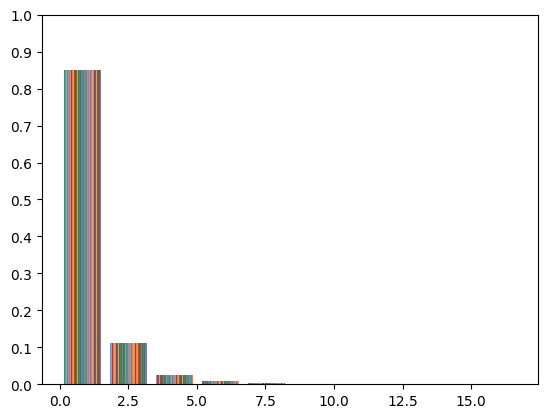

In [67]:
mse_error = []
for i in range(len(df_bay_test)):
  temp = (test_data - log_test_y) ** 2
  mse_error.append(temp)

weights = np.ones_like(mse_error) / len(df_bay_test)

pyplot.hist(mse_error, weights=weights)
pyplot.yticks(ticks=np.linspace(0,1,num=11))
pyplot.show()